# A Network  Approach towards the Indictment Document of The Romanian 1989 Revolution

Starting with the indictment document, we construct a graph in which the nodes are the people mentioned within the document, and the edge values are the number of co-occurences of each pair of characters (defendants, suspects, etc) in a paragraph. 

The idea is that if characters __A__ and __B__ are mentioned together in a paragraph, it means they have done something together or, at least, there is a factual connection. 

Then, some conclusions are drawn using pagerank and community finding.

In [1]:
import numpy as np
import pandas as pd

import os
from PyPDF2 import PdfFileReader
import re

from collections import Counter
from collections import defaultdict

import networkx as nx
import community
from community import community_louvain

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data parsing

Unfortunately, the indictment document is in pdf format, but even if _PyPDF2_  fails to recover some text fragments, the text is large enough for all the connections to be preserved in the recovered text.

In [2]:
pdfFile = [file for file in os.listdir('data') if 'pdf' in file][0]

In [3]:

with open(os.path.join('data',pdfFile),'rb') as f:
    if f:
        ipdf = PdfFileReader(f)
        text = [p.extractText() for p in ipdf.pages]

In [4]:
text[0].replace('\n',' ')

'1  Dosar nr. 11/P/2014                                                                 Extras  R E C H I Z I T O R I U  -f  -   Ziua  05,  luna  aprilie,  anul  2019      Colonel  magistrat  , procuror militar,   în cadrul  Parchetului de pe       sus (având ca o   în contextul    din decembrie 1989   a      lipsirea de libertate a multor persoane,   distrugerea  unor bunuri de patrimoniu, pe întregul teritoriu al României),  privindu- i pe               Iliescu Ion ,    i, cercetat în stare de libertate pentru     penal,  cu aplicarea art. 5 Cp.,     Voiculescu Voican Gelu , fost viceprim-ministru al Guvernului  României      ,  cu aplicarea art.5  Cp.,  '

To be able to split into paragraphs, we manually inspect a portion of the text containing a new paragraph.

In [5]:
string = 'Spre deosebire de regimul dictatorial'
[tx for tx in text if string in tx][0]

'6  \n i prea pu\n\n\n\nextern ,\n\n  Noile raporturi interna\n\nPartidului Comunist al Uniunii Sovietice, Mihail Gorbaciov, venit la con\nducerea \npartidului în martie 1985, au complicat \ni mai mult situa\nia \ncomuniste. Politica de restructurare/reformare/reorganizare a sistemului \n perestroika\n \nglasnosti\n pe care noul lider de la Kremlin a ini\niat-o în Uniunea \n\ni asupra statelor din blocul comunist. \n \n\nBucure\nti i mai ales la dogmaticul secretar general al partidului. \n Spre deosebire de regimul dictatorial ceau\nist, regimurile comuniste din \n\nprecum Ungaria, Cehoslovacia \ni Polonia au început din deceniul al optu\n\n\n-a manifestat printr-o serie de concesii atât în \ndomeniul economic, spiritual cât \ni cel politic. Nu este lipsit de importan\n\n\nionat \ni alte partide decât partidele comuniste \ni care, chiar \n\n\n \napari\nia unor nuclee opozi\nioniste fa\n\nin a unor puncte \nde vedere diferite de cele oficiale \n\n-au putut cristaliza aripi reformatoare

notice that _'[space]\n'_   marks the beginning of the paragraph

In [6]:
paragraphs = ' '.join(text).split('. \n')

In [7]:
paragraphs = [para.replace('\n','') for para in paragraphs ]

In [8]:
paragraphs[0]

'1  Dosar nr. 11/P/2014                                                               Extras R E C H I Z I T O R I U -f-  Ziua 05, luna aprilie, anul 2019    Colonel magistrat , procuror militar,  în cadrul Parchetului de pe   sus (având ca o în contextul  din decembrie 1989  a   lipsirea de libertate a multor persoane, distrugerea unor bunuri de patrimoniu, pe întregul teritoriu al României),  privindu-i pe             Iliescu Ion,  i, cercetat în stare de libertate pentru penal, cu aplicarea art. 5 Cp.,   Voiculescu Voican Gelu, fost viceprim-ministru al Guvernului României , cu aplicarea art.5 Cp.,  2    Gl. (rtr.) Rus Iosif,  fost comandant al , cercetat în stare , prev. de art. 439 lit'

We extract only letters and basic punctuation needed for names and the end of sentences

In [9]:
def clean(str):
    lista = re.findall('[a-zA-Z.-]+', str)
    return ' '.join(lista).replace(' .','.')

In [10]:
pa = [clean(para) for para in paragraphs]

In [11]:
pa[0]

'Dosar nr. P Extras R E C H I Z I T O R I U -f- Ziua luna aprilie anul Colonel magistrat procuror militar n cadrul Parchetului de pe sus av nd ca o n contextul din decembrie a lipsirea de libertate a multor persoane distrugerea unor bunuri de patrimoniu pe ntregul teritoriu al Rom niei privindu-i pe Iliescu Ion i cercetat n stare de libertate pentru penal cu aplicarea art. Cp. Voiculescu Voican Gelu fost viceprim-ministru al Guvernului Rom niei cu aplicarea art. Cp. Gl. rtr. Rus Iosif fost comandant al cercetat n stare prev. de art. lit'

Using regular expressions, we extract all the instances of two or three words starting with capital letters and joined by spaces or dashes.

In [12]:
namePattern = "[A-Z]{1}[a-z]{1,30}[- ][A-Z]{1}[a-z]{1,30}[- ]{0,1}[A-Z]{1}[a-z]{1,30} | [A-Z]{1}[a-z]{1,30}[- ][A-Z]{1}[a-z]{1,30}"

In [13]:
re.findall(namePattern, pa[0])

[' Iliescu Ion', ' Voiculescu Voican', ' Guvernului Rom', ' Rus Iosif']

In [14]:
names =  [re.findall(namePattern, para) for para in pa if 
          len(re.findall(namePattern, para)) > 0]

In [15]:
names[:3]

[[' Iliescu Ion', ' Voiculescu Voican', ' Guvernului Rom', ' Rus Iosif'],
 [' Amiral Rtr',
  ' Dumitrescu Cico',
  ' Roman Petre',
  ' Guvernului Rom',
  ' Televiziunii Rom',
  ' Postelnicu Tudor',
  ' Toma Ioan'],
 [' Comitetului Central', ' Partidului Comunist']]

Because the above method has also captured instances such as _Partidul Comunist_ that we do not need, and also because of the fact that a person can be referred in multiple ways (Cico Dumitrescu and Dumitrescu Emil are the same person), we need to manually construct a dictionary to map the names to a standard format:

In [16]:
flat_list = [item for sublist in names for item in sublist]

In [17]:
set(flat_list)

{' Academiei Militare',
 ' Actualul Cod',
 ' Alba Iulia',
 ' Alexandru Ioan',
 ' Amiral Rtr',
 ' Apoi Iliescu',
 ' Arad Cetateexpunere',
 ' Arad Uzinelor',
 ' Armatei Ministerului',
 ' Astfel Iliescu',
 ' Avioane Craiova',
 ' Biblioteca Palatul',
 ' Bibliotecii Centrale',
 ' Brucan Silviu',
 ' Bucur La',
 ' Bucure Ceauilor',
 ' Bulevard Comitetul',
 ' Calea Girocului',
 ' Casa Sc',
 ' Cazul Otopeni',
 ' Ceauescu Nicolae',
 ' Ceauescu Nicolaei',
 ' Century Dictionary',
 ' Cercetarea Evenimentelor',
 ' Chambers Twentieth',
 ' Cico Emil',
 ' Cluj-Napoca',
 ' Cod Penal',
 ' Cod Penalgenocid',
 ' Codul Penal',
 ' Codul Penalacesta',
 ' Comandament La',
 ' Comandament Militar',
 ' Comandamentul Militar',
 ' Comandamentului In',
 ' Comandamentului Militar',
 ' Comisii Senatoriale',
 ' Comitetul Central',
 ' Comitetului Central',
 ' Comitetului Judeean',
 ' Comitetului Municipal',
 ' Comitetului Politic',
 ' Conform Codului',
 ' Consiliul Militar',
 ' Consiliul Popular',
 ' Consiliului Militar

In [18]:
namesDict ={' Alexandru Ioan':'Alexandru Ioan', ' Brucan Silviu':'Brucan Silviu',
' Ceauescu Nicolae':'Ceausescu Nicolae', ' Ceauescu Nicolaei':'Ceausescu Nicolae',
' Cico Emil':'Dumitrescu Cico Emil', ' Dumitrescu Cico':'Dumitrescu Cico Emil',
' Dumitrescu Emil':'Dumitrescu Cico Emil', ' Dumitrescu Ticu':'Dumitrescu Ticu', 
' Eftimescu Nicolae':'Eftimescu Nicolae', ' Emil Prin': 'Emil Prin',' Gabrielescu Valentin':'Gabrielescu Valentin',
' Gelu Voican':'Voiculescu Voican Gelu', ' Hortopan Ion': 'Hortopan Ion', ' Iliescu Ion':'Iliescu Ion', 
' Inculpatul Dumitrescu':'Dumitrescu Cico Emil', ' Inculpatul Voiculescu':'Voiculescu Voican Gelu',
' Ion Iliescu':'Iliescu Ion', ' Iosif Rus': 'Rus Iosif', ' Mihail Gorbaciov':'Mihail Gorbaciov', 
' Milea Vasile':'Milea Vasile', ' Militaru Nicolae':'Militaru Nicolae', ' Mocanu Mircea':'Mocanu Mircea', 
' Neagoe Marin':'Neagoe Marin', ' Nicolae Ceauremedierea' :'Ceausescu Nicolae', ' Nicolae Milea':'Milea Vasile', 
' Nicolae Tudor':'Nicolae Tudor', ' Postelnicu Tudor':'Postelnicu Tudor',' Roman Petre':'Roman Petre',
' Rus Iosif':'Rus Iosif', ' Toma Ioan':'Toma Ioan', ' Tudor Postelnicu':'Postelnicu Tudor',
' Viorel Toma':'Viorel Toma', ' Vlad Iulian':'Vlad Iulian',' Vladimir Volkoff':'Vladimir Volkoff', 
' Voican Gelu':'Voiculescu Voican Gelu', ' Voican Voiculescu':'Voiculescu Voican Gelu',
' Voiculescu Gelu':'Voiculescu Voican Gelu', ' Voiculescu Voican':'Voiculescu Voican Gelu',
' Voinea Dan':'Voinea Dan', 'Dumitrescu Cico Emil ':'Dumitrescu Cico Emil', 'Rtr Rus Iosif ':'Rus Iosif',
'Voiculescu Voican Gelu ':'Voiculescu Voican Gelu'}

In [19]:
cleanNames = []
for sublist in names:
    interim = []
    for elem in sublist:
        if elem in namesDict:
            interim.append(namesDict[elem])
    interim = list(set(interim))
    if len(interim) > 1:
        cleanNames.append(interim)

In [20]:
cleanNames[:3]

[['Iliescu Ion', 'Voiculescu Voican Gelu', 'Rus Iosif'],
 ['Dumitrescu Cico Emil', 'Roman Petre', 'Toma Ioan', 'Postelnicu Tudor'],
 ['Ceausescu Nicolae', 'Mihail Gorbaciov']]

## 2. Graph Construction. Conclusions.

We construct a dataframe with the co-occurences:

In [21]:
co_occurences = defaultdict(Counter)
for tags in cleanNames:
    for key in tags:
        co_occurences[key].update(tags)
unique_tags = sorted(co_occurences)

In [22]:
df = pd.DataFrame(co_occurences).fillna(0)
df.values[[np.arange(df.shape[0])]*2] = 0

In [23]:
df

,Brucan Silviu,Ceausescu Nicolae,Dumitrescu Cico Emil,Dumitrescu Ticu,Eftimescu Nicolae,Emil Prin,Gabrielescu Valentin,Hortopan Ion,Iliescu Ion,Mihail Gorbaciov,...,Militaru Nicolae,Mocanu Mircea,Nicolae Tudor,Postelnicu Tudor,Roman Petre,Rus Iosif,Toma Ioan,Viorel Toma,Vlad Iulian,Voiculescu Voican Gelu
Brucan Silviu,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0,0.0,...,5.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,5.0
Ceausescu Nicolae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dumitrescu Cico Emil,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,...,6.0,0.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0
Dumitrescu Ticu,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eftimescu Nicolae,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Emil Prin,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gabrielescu Valentin,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hortopan Ion,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
Iliescu Ion,5.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,9.0,0.0,1.0,1.0,3.0,2.0,0.0,0.0,2.0,12.0
Mihail Gorbaciov,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We decided to drop 'Ceausescu Nicolae' and 'Mihail Gorbaciov' for the graph to be connected

In [24]:
df.drop(['Ceausescu Nicolae','Mihail Gorbaciov'], axis=1, inplace=True)
df.drop(['Ceausescu Nicolae','Mihail Gorbaciov'], axis=0, inplace=True)

In [25]:
graph = nx.from_numpy_matrix(df.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df.columns)))

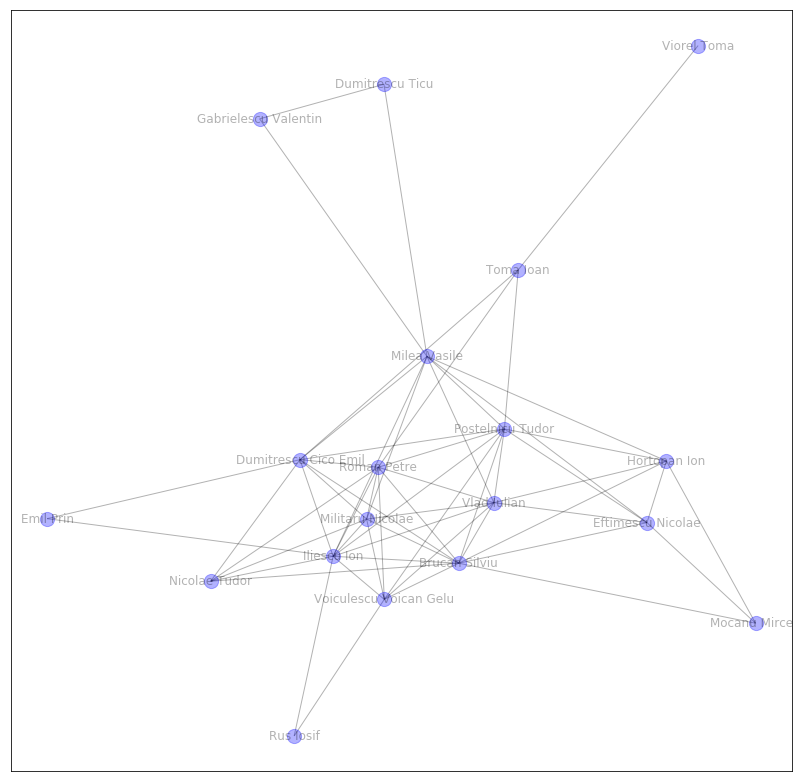

In [26]:
plt.figure(figsize=(14,14))
nx.draw_networkx(graph, pos=nx.spring_layout(graph, scale=5), arrows=False, node_size=200, with_labels=True, node_color='blue', alpha=0.3) 
#plt.savefig(os.path.join('images','image.png'))
plt.show()


The more connected to others a character is, the closer to the center is represented in the picture above

We get further insights by computing the pagerank of each node:

In [27]:
pagerank = nx.pagerank(graph)

In [28]:
rankDF = pd.DataFrame(pagerank,index=[0]).T
rankDF.columns = ['Rank']
rankDF.sort_values(by='Rank',ascending=False)

,Rank
Iliescu Ion,0.140757
Militaru Nicolae,0.116794
Voiculescu Voican Gelu,0.099276
Brucan Silviu,0.089093
Dumitrescu Cico Emil,0.075359
Roman Petre,0.065923
Vlad Iulian,0.059771
Milea Vasile,0.057586
Postelnicu Tudor,0.054589
Eftimescu Nicolae,0.037370


Next, we indentify communities within the graph:

In [29]:
part = community.best_partition(graph)
values = [part.get(node) for node in graph.nodes()]

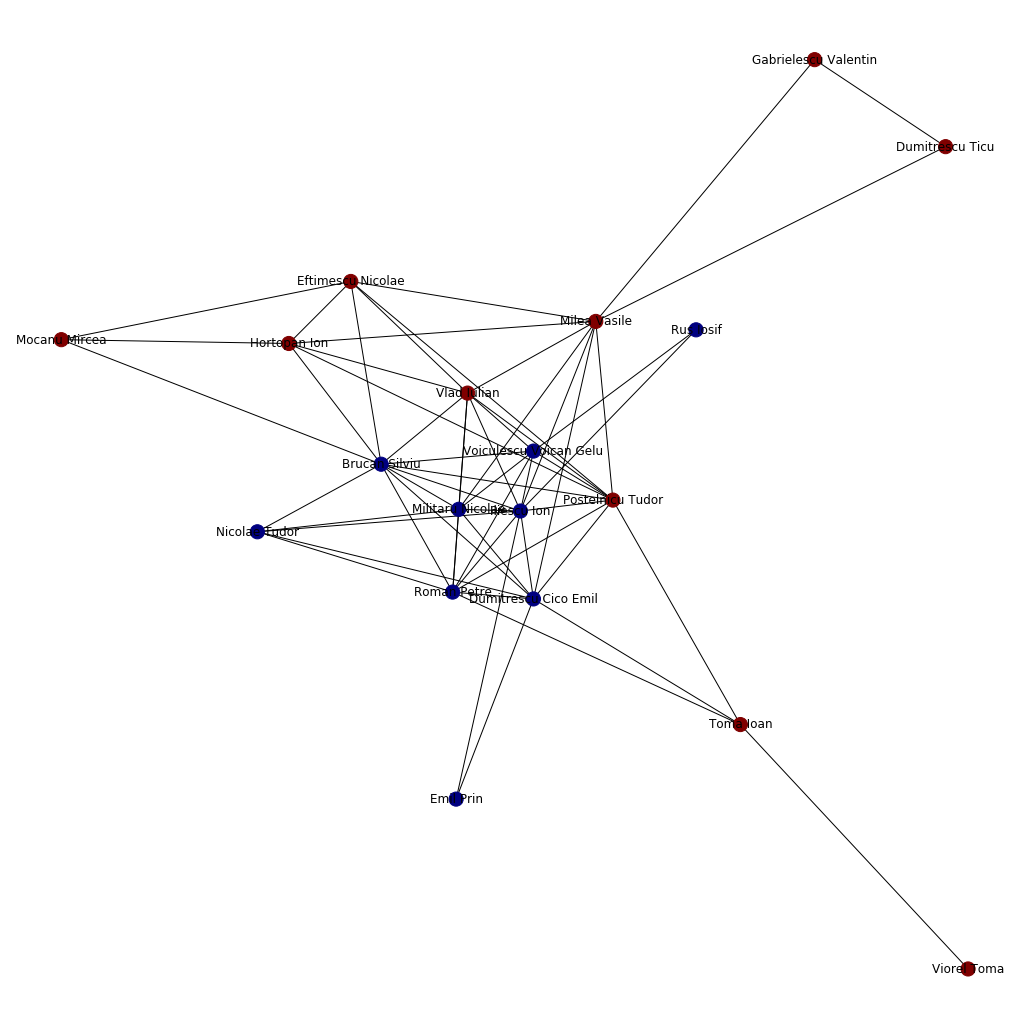

In [30]:
plt.figure(figsize=(14,14))
nx.draw_spring(graph, cmap = plt.get_cmap('jet'), node_color = values, node_size=200, with_labels=True)
plt.savefig(os.path.join('images','communities.png'))
plt.show()

There are two communities: one is formed by communist regime officials like Iulian Vlad, Tudor Postelicu, Vasile Milea, and the other consists by those who came after the 22nd of December: Iliescu, Brucan, Roman, etc